Device set to use cuda:0


Token feature shape: torch.Size([1, 2525, 384])
Patch tokens shape: torch.Size([1, 2520, 384])
Model input size (H, W): (686, 960) patch_size: 16
Random patch idx=916 at (py, px)=(15, 16))


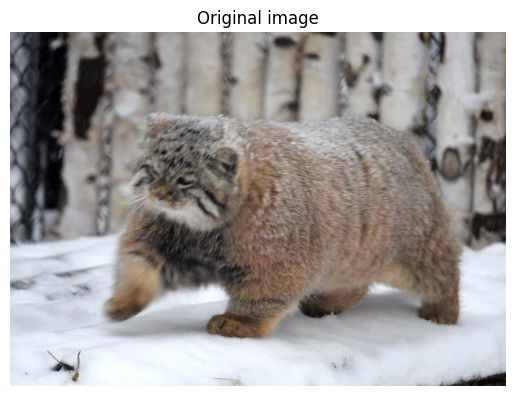

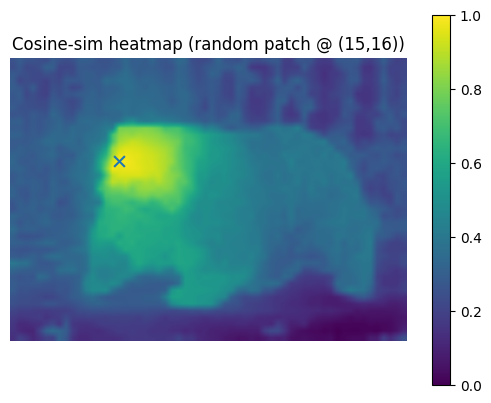

In [ ]:
# Exploration of DinoV3

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms

from transformers import pipeline
from transformers.image_utils import load_image

# ---- 1) Load image + run DINOv3 feature extraction (your starting point) ----
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
image = load_image(url)

feature_extractor = pipeline(
    model="facebook/dinov3-vits16plus-pretrain-lvd1689m",
    task="image-feature-extraction",
)

# For image-feature-extraction, this usually returns token embeddings:
# shape ~ [1, seq_len, hidden_dim] (nested lists)

p = feature_extractor.image_processor
p.default_to_square=False
p.do_resize=False

features = feature_extractor(image)

# Convert to a torch tensor: [1, seq_len, dim]
feat = torch.tensor(features, dtype=torch.float32)
if feat.ndim == 2:  # sometimes pipelines can return [seq_len, dim]
    feat = feat.unsqueeze(0)

B, S, D = feat.shape
print("Token feature shape:", feat.shape)  # [1, seq_len, hidden_dim]

# ---- 2) Figure out how many "special" tokens to skip (CLS + register tokens) ----
# DINOv3 uses CLS + register tokens; often it's 1 + 4 = 5, but we try to read config if available.
model = feature_extractor.model
patch_size = getattr(model.config, "patch_size", 16)

num_register = (
    getattr(model.config, "num_register_tokens", None)
    or getattr(model.config, "num_register", None)
    or 4
)
n_special = 1 + int(num_register)  # CLS + registers
if S <= n_special:
    raise ValueError(f"seq_len={S} is too small to contain patch tokens after n_special={n_special}")

patch_tokens = feat[:, n_special:, :]  # [1, N_patches, D]
N = patch_tokens.shape[1]
print("Patch tokens shape:", patch_tokens.shape)

# ---- 3) Get the model's internal input image size (what patches correspond to) ----
# We want the (H, W) used by the model preprocessing, not the original PIL size.
# Pipelines keep an image_processor; we can preprocess explicitly once to get pixel_values.
processor = getattr(feature_extractor, "image_processor", None)
if processor is None:
    raise RuntimeError("Pipeline has no image_processor; upgrade transformers or switch to AutoImageProcessor/AutoModel.")

inputs = processor(images=image, return_tensors="pt", default_to_square=False, do_resize=False)
pixel_values = inputs["pixel_values"]  # [1, 3, H, W]
H, W = pixel_values.shape[-2:]
print("Model input size (H, W):", (H, W), "patch_size:", patch_size)

grid_h, grid_w = H // patch_size, W // patch_size
if grid_h * grid_w != N:
    # Fallback if the processor did something odd; infer a square-ish grid
    side = int(round(np.sqrt(N)))
    if side * side == N:
        grid_h, grid_w = side, side
    else:
        raise ValueError(
            f"Cannot match patches to grid: N={N}, but (H,W)=({H},{W}) gives {H//patch_size}x{W//patch_size}={grid_h*grid_w}"
        )


# ---- 4) Normalize dense patch features (L2) ----
# patch_tokens: [1, N, D]
patch_tokens = patch_tokens.squeeze(0)                 # [N, D]
patch_tokens = F.normalize(patch_tokens, dim=1)        # [N, D] unit length

# ---- 5) Choose a random patch (equivalent to "tapping" one patch) ----
rng = np.random.default_rng()
# rand_idx = int(rng.integers(low=0, high=N))
# py, px = divmod(rand_idx, grid_w)
py, px = 15, 16
rand_idx = py*grid_w+px
cx = (px + 0.5) * patch_size
cy = (py + 0.5) * patch_size
print(f"Random patch idx={rand_idx} at (py, px)=({py}, {px}))")

# ---- 6) Cosine similarity of clicked patch vs all patches ----
# Since vectors are unit-normalized, cosine similarity = dot product
v = patch_tokens[rand_idx]                 # [D]
sim = patch_tokens @ v                     # [N]
sim_grid = sim.reshape(grid_h, grid_w)     # [grid_h, grid_w]

# ---- 7) Upsample similarity map to image resolution for a heatmap in image-shape ----
# sim_grid -> [1,1,grid_h,grid_w] -> upsample to [1,1,H,W]
sim_up = F.interpolate(
    sim_grid[None, None, :, :],
    size=(H, W),
    mode="bilinear",
    align_corners=False,
).squeeze().cpu().numpy()  # [H, W]

# ---- 8) Plot: original image + heatmap ----
plt.figure()
plt.title("Original image")
# When plotting, image should be PIL Image or NumPy array, not a tensor
# Convert tensor back to PIL Image or NumPy array for imshow if necessary
plt.imshow(image)
plt.axis("off")

plt.figure()
plt.title(f"Cosine-sim heatmap (random patch @ ({py},{px}))")
plt.imshow(sim_up)  # default colormap
plt.scatter([cx], [cy], s=60, marker="x")
plt.colorbar()
plt.axis("off")

plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from typing import Tuple
from torch import Tensor
import torch.nn as nn
import math
import random
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer, Siglip2TextModel
from transformers.image_utils import load_image
from pycocotools.coco import COCO
import os
from PIL import Image
from tqdm.auto import tqdm, trange
import wandb
from pathlib import Path
import json, os, random, math, numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Global Hyperparameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SHARED_EMB = 384
DINOv3_MODEL_URI = "facebook/dinov3-vits16plus-pretrain-lvd1689m"
SigLIP2_MODEL_URI = "google/siglip2-base-patch16-512"
DEVICE = "cuda"
IMG_SIZE = 512
GREF_JSON  = "/content/drive/MyDrive/datasets/grefs(unc).json"
INST_JSON  = "/content/drive/MyDrive/datasets/instances.json"
IMG_DIR    = "/content/drive/MyDrive/datasets/coco/train2014/gref_images"

In [ ]:
# load models

v_backbone = AutoModel.from_pretrained(
    DINOv3_MODEL_URI,
    device_map="auto",
)
im_processor = AutoImageProcessor.from_pretrained(DINOv3_MODEL_URI)

t_backbone = Siglip2TextModel.from_pretrained(SigLIP2_MODEL_URI, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(SigLIP2_MODEL_URI)

v_backbone.to(DEVICE)
t_backbone.to(DEVICE)

config.json:   0%|          | 0.00/742 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

You are using a model of type siglip_text_model to instantiate a model of type siglip2_text_model. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Siglip2TextModel(
  (text_model): Siglip2TextTransformer(
    (embeddings): Siglip2TextEmbeddings(
      (token_embedding): Embedding(256000, 768)
      (position_embedding): Embedding(64, 768)
    )
    (encoder): Siglip2Encoder(
      (layers): ModuleList(
        (0-11): 12 x Siglip2EncoderLayer(
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attn): Siglip2Attention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Siglip2MLP(
            (activation_fn): GELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, 

In [ ]:
class VisionBranch(nn.Module):
  """
  Vision Branch Using our DinoV3 model, adapted to our task with LoRA
  """
  def __init__(self, backbone, processor):
    super().__init__()
    self.backbone = backbone
    self.processor = processor
    self.processor.default_to_square=False
    self.processor.do_resize=False

    self.patch_size = getattr(backbone.config, "patch_size")
    self.num_register_tokens = getattr(backbone.config, "num_register_tokens")
    self.num_special_tokens = 1 + self.num_register_tokens

  def forward(self, images=None):
    batch = self.processor(images=images, return_tensors="pt").to(next(self.backbone.parameters()).device)
    out = self.backbone(**batch)
    tokens = out.last_hidden_state
    patch_tokens = tokens[:, self.num_special_tokens:, :]
    cls_token = tokens[:, 0, :]

    return patch_tokens, cls_token #(batches, patches, dimensions)

In [ ]:
class TextBranch(nn.Module):
  """
  Text Tower Using SigLIP2's text tower, adapter with LoRA
  """
  def __init__(self, backbone, tokenizer, back_dim=768, max_length=64):
    super().__init__()
    self.backbone = backbone
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.down_proj = nn.Linear(back_dim, SHARED_EMB, bias=False)

  def forward(self, captions=None):
    inputs = self.tokenizer(
        captions,
        padding="max_length",
        truncation=True,
        max_length=self.max_length,
        return_tensors="pt",
        return_attention_mask=True
    ).to(next(self.backbone.parameters()).device)

    out = self.backbone(**inputs)
    text_features = out.last_hidden_state
    text_features = self.down_proj(text_features)
    attn_mask = inputs['attention_mask']
    mask = attn_mask.unsqueeze(-1).float()
    t_global = (text_features * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)

    return text_features, attn_mask, t_global #(batches, dimensions)

In [ ]:
# LoRA Adaptation

# Helper Functions

def freeze_all_params(module: torch.nn.Module):
  """
  Freeze parameters
  """
  for p in module.parameters():
    p.requires_grad = False

def unfreeze_all_params(module: torch.nn.Module):
  """
  UNFreeze parameters
  """
  for p in module.parameters():
    p.requires_grad = True

def count_trainables(module: torch.nn.Module):
  """
  Count Trainable Parameters
  """

  total = 0
  trainable = 0
  names = []
  for n, p in module.named_parameters():
      num = p.numel()
      total += num
      if p.requires_grad:
          trainable += num
          names.append(n)
  return total, trainable, names


In [ ]:
from peft import LoraConfig, get_peft_model
def apply_lora(model: nn.Module, targets: list[str], r: int, alpha: int, dropout:float):
  freeze_all_params(model)
  lora_config = LoraConfig(
      r=r,
      lora_alpha=alpha,
      lora_dropout=dropout,
      target_modules=targets,

  )
  model = get_peft_model(model, lora_config)
  return model

In [ ]:
def preview_module_names(m: torch.nn.Module, needles=["q_proj","k_proj","v_proj","o_proj",
  "gate_proj","up_proj","down_proj",]
):
    hits = []
    for name, mod in m.named_modules():
        lname = name.lower()
        if any(k in lname for k in needles):
            # keep it short
            hits.append((name, mod.__class__.__name__))
    for x in hits[:60]:
        print(x)
    print(f"... printed {min(len(hits), 60)} of {len(hits)} matches")


In [ ]:
text_targets = vision_targets = ["q_proj","k_proj","v_proj","o_proj",
  "gate_proj","up_proj","down_proj",]

vision_model = apply_lora(v_backbone, targets=vision_targets,
                          r = 8,
                          alpha=16,
                          dropout=0.0
                          )

vision_branch = VisionBranch(backbone=vision_model, processor=im_processor).to(DEVICE)


text_model = apply_lora(t_backbone, targets=text_targets, r=8, alpha=16, dropout=0.0)
text_branch = TextBranch(backbone=text_model, tokenizer=tokenizer).to(DEVICE)

In [ ]:
class CrossAttn(nn.Module):
  def __init__(self, q_dim, kv_dim, common_dim: int, heads: int, dropout=0.0):
    super().__init__()
    # check if number of heads perfectly divides common embedding dimension
    assert common_dim % heads == 0
    self.common_dim = common_dim
    self.heads = heads
    self.head_dim = common_dim//heads

    self.q_proj = nn.Linear(q_dim, common_dim, bias=False)
    self.k_proj = nn.Linear(kv_dim, common_dim, bias=False)
    self.v_proj = nn.Linear(kv_dim, common_dim, bias=False)

    self.o_proj = nn.Linear(common_dim, q_dim, bias=False)

    self.dropout = nn.Dropout(dropout)
    self.norm_q = nn.LayerNorm(q_dim)
    self.norm_kv = nn.LayerNorm(kv_dim)

  def forward(self, q_tokens, kv_tokens, kv_mask):
    q_tokens = self.norm_q(q_tokens) # (B, N, q_dim)
    kv_tokens = self.norm_kv(kv_tokens) # (B, L, kv_dim)

    Q = self.q_proj(q_tokens) # (B, N, common_dim)
    B, N, _ = Q.shape
    # reshape
    Q = Q.view(B, N, self.heads, self.head_dim) # (B, N, heads, head_dim)
    Q = Q.transpose(1,2) # (B, heads, N, head_dim)

    K = self.k_proj(kv_tokens)
    L = K.shape[1]
    # reshape
    K = K.view(B, L, self.heads, self.head_dim) #(B, L, heads, head_dim)
    K = K.transpose(1,2) #(B, heads, L, head_dim)

    V = self.v_proj(kv_tokens)
    # reshape
    V = V.view(B, L, self.heads, self.head_dim)
    V = V.transpose(1,2) #(B, heads, L, head_dim)


    # compute attention scores
    scores = (Q @ K.transpose(-2, -1)) * (self.head_dim ** -0.5) # (B, heads, N, L)

    # mask
    mask = kv_mask[:, None, None, :].to(dtype=torch.bool)
    scores = scores.masked_fill(~mask, float("-inf"))

    attn = scores.softmax(-1) #along L (why?)
    attn = self.dropout(attn)

    out = attn @ V # (B, heads, N, head_dim)
    out = out.transpose(1, 2).contiguous().view(B, N, self.common_dim)

    out = self.o_proj(out)  # (B, N, q_dim)
    return out

In [ ]:
class SegmentationHead(nn.Module):
  def __init__(self, in_dim, hidden_dim = 512):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(in_dim, hidden_dim, bias=True),
        nn.GELU(),
        nn.Linear(hidden_dim, 1)

    )

  def forward(self, patch_tokens, Hp=32, Wp=32, out_size = 512):
    B, N, emb = patch_tokens.shape
    patch_logits = self.mlp(patch_tokens) #(B, N, 1)
    patch_logits = patch_logits.squeeze(-1) #(B, N)

    # reshape
    patch_logits = patch_logits.view(B, 1, Hp, Wp)

    mask_logits = nn.functional.interpolate(
        patch_logits,
        size=(out_size, out_size),
        mode='bilinear',
    )

    return mask_logits



In [ ]:
# Wrapper Model

class SegmentionModel(nn.Module):
  def __init__(self, v_backbone, im_processor, t_backbone, tokenizer, shared_emb=SHARED_EMB, attn_dim=768):
    super().__init__()

    # Vision Branch
    self.vision_branch = VisionBranch(backbone=v_backbone, processor=im_processor)

    # Text Branch
    self.text_branch = TextBranch(backbone=t_backbone, tokenizer=tokenizer)

    # Cross Attn
    self.cross_attn = CrossAttn(shared_emb, shared_emb, attn_dim, 4)

    # Seg Head
    self.seg_head = SegmentationHead(shared_emb)

    # Contrastive loss parameter
    init_logit_scale = math.log(1/0.07)
    self.logit_scale = nn.Parameter(torch.tensor(init_logit_scale, dtype=torch.float32))

  def forward(self, images, captions):
    v_tokens, v_global = self.vision_branch(images)
    t_tokens, attn_mask, t_global = self.text_branch(captions)
    v_ctx = self.cross_attn(v_tokens, t_tokens, attn_mask)
    v_tokens = v_tokens + v_ctx
    logits = self.seg_head(v_tokens)

    return logits, v_global, t_global



In [ ]:
# Data Loading - Inputs and Masked Outputs

In [ ]:
def prep_data(train_entries, val_entries, *, row_cap=10000, train_ratio=0.8):
  split_idx     = int(row_cap * train_ratio)
  train_subset  = train_entries[:split_idx]

  train_vocab = set()
  for e in train_subset:
      for s in e["sentences"]:
          train_vocab |= set(tokenizer.tokenize(s["sent"].lower()))

  def caption_in_vocab(entry, vocab):
      return all(
          set(tokenizer.tokenize(s["sent"].lower())).issubset(vocab)
          for s in entry["sentences"]
      )

  test_subset  = []
  start = 0
  limit = int(row_cap * (1-train_ratio))

  for e in val_entries:
    if start > limit:
      break
    if caption_in_vocab(e, train_vocab):
      test_subset.append(e)
      start+=1



  print(f"Final  train refs = {len(train_subset):,}  "
        f"(= {len(train_subset)/row_cap:.0%} of {row_cap})")
  print(f"Final  test  refs = {len(test_subset):,}  "
        f"(= {len(test_subset)/row_cap:.0%} of {row_cap})")

  return train_subset, test_subset

In [ ]:
# Building the Corpus

with open(GREF_JSON) as f:
    gref = json.load(f)

def coco_name(iid: int) -> str:
    return f"COCO_train2014_{iid:012d}.jpg"

train_entries, test_entries = [], []
for e in gref:
    if e.get("no_target") or not e["sentences"] or not e["ann_id"]:
        continue
    img_path = os.path.join(IMG_DIR, coco_name(e["image_id"]))
    if not os.path.isfile(img_path):
        continue
    trg = train_entries if e.get("split", "train") == "train" else test_entries
    trg.append(e)

print(f"Full Corpus Details:")
print(f"# Training Segments = {len(train_entries):,}")
print(f"# Testing Segments = {len(test_entries):,}")

Full Corpus Details:
# Training Segments = 67,464
# Testing Segments = 14,510


In [ ]:
# Initialize coco
coco = COCO(INST_JSON)

loading annotations into memory...
Done (t=7.08s)
creating index...
index created!


In [ ]:
# Helper Functions
def ann_ids_to_mask(ann_ids, wh):
  """
  Return the OR union of all annotaion masks
  """
  W, H = wh
  m = np.zeros((H, W), np.uint8)
  for aid in ann_ids:
    if aid in coco.anns:
      m |= coco.annToMask(coco.anns[aid]).astype(np.uint8)
  return m

def give_PIL(paths):
  images = []
  for path in paths:
    images.append(Image.open(path).convert("RGB").resize(
        (IMG_SIZE,IMG_SIZE),
        Image.BILINEAR))
  return tuple(images)



In [ ]:
# Create Dataset Class
class GRefDataset(Dataset):

  def __init__(self, entries, img_dir, img_size):
    self.samples, self.img_dir, self.img_size = [], img_dir, img_size
    for e in entries:
      path = os.path.join(img_dir, coco_name(e["image_id"]))
      if not os.path.isfile(path): continue
      for s in e["sentences"]:
        self.samples.append(dict(
          img_id  = e["image_id"],
          path    = path,
          ann_ids = e["ann_id"],
          text    = s["sent"]
      ))
    if not self.samples: raise RuntimeError("No samples")

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    s = self.samples[idx]
    W,H = Image.open(s["path"]).size
    m = ann_ids_to_mask(s["ann_ids"], (W,H))
    m = Image.fromarray(m*255).resize((IMG_SIZE,IMG_SIZE), Image.NEAREST)
    m = torch.from_numpy(np.array(m)//255)[None].float()
    return s["path"], m, s["text"], s["img_id"]

In [ ]:
# cross_attn = CrossAttn(384,768,1024,4).to(DEVICE)
# seg_head = SegmentationHead(384).to(DEVICE)

In [ ]:
# Visualization

def show_visual_comparison(img, gt, pred, caption):
  img = np.array(img.convert("RGB"))
  H, W = img.shape[:2]

  gt = gt.detach().cpu().squeeze(0).numpy()
  pred = pred.detach().cpu().squeeze(0).numpy()

  assert gt.shape[:2] == (H, W)
  assert pred.shape[:2] == (H, W)

  red = np.zeros((H, W, 3), dtype=np.uint8)
  red[..., 0] = 255

  alpha_gt = (gt.astype(np.float32) * 0.35)

  pred = pred.astype(np.float32)
  pred = np.clip(pred, 0.0, 1.0)
  pred = (pred >= 0.5).astype(np.float32)
  alpha_pred = (pred * 0.35)

  overlay_gt = np.zeros((H, W, 4), dtype=np.float32)
  overlay_gt[..., 0] = 1.0
  overlay_gt[..., 3] = alpha_gt.astype(np.float32)

  overlay_pred = np.zeros((H, W, 4), dtype=np.float32)
  overlay_pred[..., 0] = 1.0
  overlay_pred[..., 3] = alpha_pred.astype(np.float32)

  # Plot
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  for ax in axes:
      ax.axis("off")

  # Left: GT
  axes[0].imshow(img)
  axes[0].imshow(overlay_gt)
  axes[0].set_title("GT")

  # Right: Pred
  axes[1].imshow(img)
  axes[1].imshow(overlay_pred)
  axes[1].set_title("Pred")

  # Caption
  fig.subplots_adjust(bottom=0.18)
  fig.text(0.5, 0.04, caption, ha="center")

  return fig



In [ ]:
# Loss Functions

def contrastive_allignment_loss(vision_embs, text_embs,logit_scale, *, eps=1e-8):
  B = vision_embs.shape[0]
  v = F.normalize(vision_embs, dim=1, eps=eps)
  t = F.normalize(text_embs, dim=1, eps=eps)

  logit_scale_clamped = torch.clamp(logit_scale, min=0, max=math.log(100))
  scale = torch.exp(logit_scale_clamped)

  logits = scale * (v @ t.T)

  targets = torch.arange(B, device=logits.device)

  loss_i2t = F.cross_entropy(logits, targets)
  loss_t2i = F.cross_entropy(logits.T, targets)

  return 0.5 * (loss_i2t + loss_t2i)



In [ ]:
# Pretraining Helpers

def save_checkpoint(path, *, model, optimizer, epoch, best_metric, scaler=None):
  payload = {
      "epoch": epoch,
      "best_metric": best_metric,
      "model": model.state_dict(),
      "optimizer": optimizer.state_dict(),
  }
  if scaler is not None:
      payload["scaler"] = scaler.state_dict()
  torch.save(payload, path)

def maybe_resume(save_dir, *, model, optimizer, scaler=None, device=DEVICE):
  save_dir = Path(save_dir)
  latest_path = save_dir / "latest.pt"
  if not latest_path.exists():
      return 0, float("inf")

  ckpt = torch.load(latest_path, map_location=device)
  model.load_state_dict(ckpt["model"])
  optimizer.load_state_dict(ckpt["optimizer"])
  if scaler is not None and "scaler" in ckpt:
      scaler.load_state_dict(ckpt["scaler"])

  start_epoch = ckpt["epoch"] + 1
  best_metric = ckpt.get("best_metric", float("inf"))
  print(f"[train] resumed from {latest_path} @ epoch={start_epoch}, best={best_metric}")
  return start_epoch, best_metric

In [ ]:
# one pretraining epoch

def one_pretrain_epoch(model, train_dl, optimizer):
  model.train()
  total, n = 0.0, 0

  pbar = tqdm(train_dl, desc="pretrain/train", leave=False)
  for step, (paths, masks, captions, im_ids) in enumerate(pbar, 1):
    imgs = give_PIL(paths)
    optimizer.zero_grad(set_to_none=True)

    with torch.autocast(DEVICE, dtype=torch.bfloat16, enabled=True):
      _, v_global, t_global = model(list(imgs), list(captions))
      loss = contrastive_allignment_loss(v_global, t_global, model.logit_scale)
    loss.backward()
    optimizer.step()

    bs = len(imgs)
    total += loss.item() * bs
    n += bs

    pbar.set_postfix(loss=f"{loss.item():.4f}", scale=f"{model.logit_scale.exp().item():.2f}")

  return total / max(n, 1)


In [ ]:
@torch.no_grad()
def one_pretrain_eval(model, val_dl):
  model.eval()
  total, n = 0.0, 0
  pbar = tqdm(val_dl, desc="pretrain/val", leave=False)
  for step, (paths, masks, captions, im_ids) in enumerate(pbar, 1):
    imgs = give_PIL(paths)
    with torch.autocast(DEVICE, dtype=torch.bfloat16, enabled=True):
      _, v_global, t_global = model(list(imgs), list(captions))
      loss = contrastive_allignment_loss(v_global, t_global, model.logit_scale)

    bs = len(imgs)
    total += loss.item() * bs
    n += bs

    pbar.set_postfix(loss=f"{loss.item():.4f}")

  return total / max(n, 1)

In [ ]:
def pretrain_contrastive(model, train_dl, val_dl, *, save_dir, epochs, lr, device=DEVICE,
                         project="contrastive-pretrain", run_name=None, patience=5, min_del=0.0):

  model.to(device)

  wandb.init(project=project, name=run_name, config={
      "epochs": epochs,
      "lr": lr,
      "device": str(device),
      "patience": patience,
      "min_delta": min_del,
  })

  optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

  start_epoch, best_val = maybe_resume(save_dir, model=model, optimizer=optimizer, device=device)

  bad_epochs = 0

  for epoch in tqdm(range(start_epoch, epochs), desc="pretrain/epochs"):
      train_loss = one_pretrain_epoch(model, train_dl, optimizer)
      val_loss   = one_pretrain_eval(model, val_dl)

      improved = (best_val - val_loss) > min_del

      if improved:
            best_val = val_loss
            bad_epochs = 0
      else:
          bad_epochs += 1

      wandb.log({
          "epoch": epoch,
          "train/contrastive_loss": train_loss,
          "val/contrastive_loss": val_loss,
          "logit_scale": float(model.logit_scale.item()),
          "scale": float(model.logit_scale.exp().item()),
          "early_stop/bad_epochs": bad_epochs,
          "early_stop/improved": int(improved),
          "early_stop/patience": patience,
      })

      # latest
      save_checkpoint(Path(save_dir) / "latest.pt",
                      model=model, optimizer=optimizer, epoch=epoch, best_metric=best_val)

      # best
      if improved:
          best_val = val_loss
          save_checkpoint(Path(save_dir) / "best.pt",
                          model=model, optimizer=optimizer, epoch=epoch, best_metric=best_val)

      if bad_epochs >= patience:
          tqdm.write(f"[early stop] epoch={epoch} val_loss={val_loss:.6f} "
                      f"(best={best_val:.6f}), bad_epochs={bad_epochs}/{patience}")
          break


In [ ]:
pretrain_train, pretrain_test = prep_data(train_entries, test_entries)

Final  train refs = 8,000  (= 80% of 10000)
Final  test  refs = 2,000  (= 20% of 10000)


In [ ]:
# Initialize DataLoader
train_dl = DataLoader(
    GRefDataset(pretrain_train, IMG_DIR, IMG_SIZE),
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

test_dl = DataLoader(
    GRefDataset(pretrain_test, IMG_DIR, IMG_SIZE),
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

In [ ]:
# Initialize Model
model = SegmentionModel(vision_model, im_processor, text_model, tokenizer).to(DEVICE)

In [ ]:
# Test Run
pretrain_contrastive(model, train_dl, test_dl, save_dir="/content/drive/MyDrive/datasets/pretrain_ckpts", epochs=20,lr=1e-4, run_name="Big Pretraining Phase")

pretrain/epochs:   0%|          | 0/20 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

pretrain/train:   0%|          | 0/354 [00:00<?, ?it/s]

pretrain/val:   0%|          | 0/70 [00:00<?, ?it/s]

[early stop] epoch=13 val_loss=2.407249 (best=2.340105), bad_epochs=5/5


In [ ]:
# Load best model

def load_best_model(save_dir, *, model):
  save_dir=Path(save_dir)
  best_path = save_dir / "best.pt"
  if not best_path.exists():
    raise FileNotFoundError(f"No {best_path} file found")

  ckpt = torch.load(best_path, map_location=DEVICE)
  model.load_state_dict(ckpt["model"])
  print("Sanity Check: Pretrain Epoch:", ckpt["epoch"])

  return


In [ ]:
def dice_loss_binary(logits, target, *, eps=1e-6):
  """
  logits: (B,1,H,W) float (raw logits if from_logits=True)
  target: (B,1,H,W) or (B,H,W) with {0,1} (or float 0..1)
  """

  # 1) Shape sanitize
  if target.ndim == 3:
    target = target.unsqueeze(1)
  target = target.float()

  # 2) Convert logits -> probs
  probs = torch.sigmoid(logits)

  # 3) Calculate per-image dice
  dims = (2,3)

  intersection = torch.sum(probs * target, dim=dims)
  denom = torch.sum(probs + target, dim=dims)

  dice = (2.0 * intersection + eps) / (denom + eps)
  loss = 1.0 - dice

  return loss.mean()


In [ ]:
def focal_loss_binary(logits, target, *, gamma=2.0, alpha=0.25, eps=1e-8):
  """
  logits: (B,1,H,W)
  target: (B,1,H,W) or (B,H,W) with {0,1}
  alpha: weight for positives (common ~0.25). negatives get (1-alpha).
  """

  if target.ndim == 3:
      target = target.unsqueeze(1)
  target = target.float()


  # 1) Compute base BCE (stable)
  bce = F.binary_cross_entropy_with_logits(logits, target, reduction="none")
  p   = torch.sigmoid(logits)

  # 2) Compute p_t (prob assigned to the true label)
  p_t = p * target + (1.0 - p) * (1.0 - target)

  # 3) Focal factor
  focal_factor = (1.0 - p_t).pow(gamma)

  # 4) Alpha weighting per pixel
  alpha_t = alpha * target + (1.0 - alpha) * (1.0 - target)

  loss = alpha_t * focal_factor * bce

  return loss.mean()


In [ ]:
def combined_seg_loss(logits, target, *,lambda_dice=1, lambda_focal=1):

  ld = dice_loss_binary(logits, target)
  lf = focal_loss_binary(logits, target)

  return lambda_dice * ld + lambda_focal * lf

In [ ]:
# Training Helpers

def set_trainable_seg_only(model):
  for p in model.parameters():
      p.requires_grad = False
  for p in model.cross_attn.parameters():
      p.requires_grad = True
  for p in model.seg_head.parameters():
      p.requires_grad = True
  model.logit_scale.requires_grad = False

  # sanity check print
  trainable = [(n, p) for n, p in model.named_parameters() if p.requires_grad]
  n_params = sum(p.numel() for _, p in trainable)
  print(f"[post-train] trainable tensors: {len(trainable)} | trainable params: {n_params:,}")

In [ ]:
@torch.no_grad()
def log_random_viz_from_loader(model, dl, *, tag):
  model.eval()
  # grab one batch
  paths, masks, captions, im_ids = next(iter(dl))
  imgs = give_PIL(paths)

  idx = random.randrange(len(imgs))
  img = imgs[idx]
  gt  = masks[idx]
  cap = captions[idx]

  with torch.autocast(DEVICE, dtype=torch.bfloat16, enabled=True):
      seg_logits, _, _ = model([img], [cap])
      pred = torch.sigmoid(seg_logits).squeeze(1)

  fig = show_visual_comparison(img, gt, pred, cap)
  wandb.log({tag: wandb.Image(fig)})
  plt.close(fig)

In [ ]:
def train_one_epoch_seg(model, train_dl, optimizer):
  model.train()
  total, n = 0.0, 0

  pbar = tqdm(train_dl, desc="post/train", leave=False)
  for step, (paths, masks, captions, im_ids) in enumerate(pbar, 1):
    imgs = give_PIL(paths)

    # target mask to device; expect (B,1,H,W) or (B,H,W)
    if masks.ndim == 3:
        masks = masks.unsqueeze(1)
    masks = masks.to(DEVICE).float()

    optimizer.zero_grad(set_to_none=True)

    with torch.autocast(DEVICE, dtype=torch.bfloat16, enabled=True):
      seg_logits, _, _ = model(list(imgs), list(captions))  # (B,1,h,w)
      loss = combined_seg_loss(seg_logits, masks, lambda_dice=1, lambda_focal=1)

    loss.backward()
    optimizer.step()

    bs = masks.shape[0]
    total += loss.item() * bs
    n += bs

    pbar.set_postfix(loss=f"{loss.item():.4f}")

  return total / max(n, 1)

@torch.no_grad()
def eval_one_epoch_seg(model, val_dl):
  model.eval()
  total, n = 0.0, 0

  pbar = tqdm(val_dl, desc="post/val", leave=False)
  for step, (paths, masks, captions, im_ids) in enumerate(pbar, 1):
    imgs = give_PIL(paths)

    if masks.ndim == 3:
      masks = masks.unsqueeze(1)
    masks = masks.to(DEVICE).float()

    with torch.autocast(DEVICE, dtype=torch.bfloat16, enabled=True):
      seg_logits, _, _ = model(list(imgs), list(captions))
      loss = combined_seg_loss(seg_logits, masks, lambda_dice=1, lambda_focal=1)

    bs = masks.shape[0]
    total += loss.item() * bs
    n += bs

    pbar.set_postfix(loss=f"{loss.item():.4f}")

  return total / max(n, 1)


In [ ]:
def post_train_segmentation(model, train_dl, val_dl, *,
                            save_dir,
                            epochs,
                            lr=3e-4,
                            project="seg-post-train",
                            run_name=None,
                            patience=5,
                            min_delta=0.0):

  model.to(DEVICE)

  # freeze + sanity print
  set_trainable_seg_only(model)

  # new optimizer ONLY over trainable params
  trainable_params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.AdamW(trainable_params, lr=lr, weight_decay=1e-2)

  # wandb init (safe if already inited elsewhere)
  if wandb.run is None:
      wandb.init(project=project, name=run_name, config={
          "epochs": epochs,
          "lr": lr,
          "device": DEVICE,
          "phase": "post_train_segmentation",
          "patience": patience,
      })

  save_dir = Path(save_dir)
  save_dir.mkdir(parents=True, exist_ok=True)

  # resume from post-train directory
  start_epoch, best_val = maybe_resume(save_dir, model=model, optimizer=optimizer)

  bad_epochs = 0

  # epoch loop (tqdm)
  for epoch in tqdm(range(start_epoch, epochs), desc="post/epochs"):
      train_loss = train_one_epoch_seg(model, train_dl, optimizer)
      val_loss   = eval_one_epoch_seg(model, val_dl)

      improved = (best_val - val_loss) > min_delta
      if improved:
          best_val = val_loss
          bad_epochs = 0
      else:
          bad_epochs += 1

      wandb.log({
          "epoch": epoch,
          "train/seg_loss": train_loss,
          "val/seg_loss": val_loss,
          "train/lr": lr,
          "early_stop/bad_epochs": bad_epochs,
          "early_stop/improved": int(improved),
          "early_stop/patience": patience,
      })

      # save latest
      save_checkpoint(save_dir / "latest.pt",
                      model=model, optimizer=optimizer, epoch=epoch, best_metric=best_val)

      # save best (lower val_loss is better)
      if improved:
          save_checkpoint(save_dir / "best.pt",
                          model=model, optimizer=optimizer, epoch=epoch, best_metric=best_val)

      if bad_epochs >= patience:
          tqdm.write(f"[early stop] epoch={epoch} val_loss={val_loss:.6f} "
                      f"(best={best_val:.6f}), bad_epochs={bad_epochs}/{patience}")
          break

      # viz schedule: every 2 epochs AND final epoch
      is_viz_epoch = (epoch % 2 == 0) or (epoch == epochs - 1)
      if is_viz_epoch:
          log_random_viz_from_loader(model, train_dl, tag=f"viz/train_{epoch}")
          log_random_viz_from_loader(model, val_dl, tag=f"viz/val_{epoch}")

In [ ]:
pretrained_model = SegmentionModel(vision_model, im_processor, text_model, tokenizer).to(DEVICE)
load_best_model("/content/drive/MyDrive/datasets/pretrain_ckpts", model=pretrained_model)
set_trainable_seg_only(pretrained_model)

Sanity Check: Pretrain Epoch: 5
[post-train] trainable tensors: 12 | trainable params: 1,378,817


In [ ]:
# Post Training Loop
pretrained_model = SegmentionModel(vision_model, im_processor, text_model, tokenizer).to(DEVICE)
load_best_model("/content/drive/MyDrive/datasets/pretrain_ckpts", model=pretrained_model)

post_train_segmentation(pretrained_model, train_dl, test_dl, save_dir="/content/drive/MyDrive/datasets/postrain_ckpts", epochs=20, run_name="Big Post Training")

Sanity Check: Pretrain Epoch: 8
[post-train] trainable tensors: 12 | trainable params: 1,378,817


post/epochs:   0%|          | 0/20 [00:00<?, ?it/s]

post/train:   0%|          | 0/354 [00:00<?, ?it/s]

post/val:   0%|          | 0/70 [00:00<?, ?it/s]

post/train:   0%|          | 0/354 [00:00<?, ?it/s]

post/val:   0%|          | 0/70 [00:00<?, ?it/s]

post/train:   0%|          | 0/354 [00:00<?, ?it/s]

post/val:   0%|          | 0/70 [00:00<?, ?it/s]

post/train:   0%|          | 0/354 [00:00<?, ?it/s]

post/val:   0%|          | 0/70 [00:00<?, ?it/s]

post/train:   0%|          | 0/354 [00:00<?, ?it/s]

post/val:   0%|          | 0/70 [00:00<?, ?it/s]

post/train:   0%|          | 0/354 [00:00<?, ?it/s]

post/val:   0%|          | 0/70 [00:00<?, ?it/s]

post/train:   0%|          | 0/354 [00:00<?, ?it/s]

post/val:   0%|          | 0/70 [00:00<?, ?it/s]

post/train:   0%|          | 0/354 [00:00<?, ?it/s]

post/val:   0%|          | 0/70 [00:00<?, ?it/s]

post/train:   0%|          | 0/354 [00:00<?, ?it/s]

post/val:   0%|          | 0/70 [00:00<?, ?it/s]

[early stop] epoch=8 val_loss=0.515475 (best=0.496278), bad_epochs=5/5


In [ ]:
def verify_data_leakage(train_loader, test_loader):
    # Extract samples from the datasets
    train_samples = train_loader.dataset.samples
    test_samples = test_loader.dataset.samples

    print(f"Analyzing {len(train_samples)} training samples and {len(test_samples)} testing samples...")

    # 1. Check Image ID Overlap
    train_img_ids = set(s['img_id'] for s in train_samples)
    test_img_ids = set(s['img_id'] for s in test_samples)

    img_intersection = train_img_ids.intersection(test_img_ids)

    print("\n--- Image Overlap Check ---")
    print(f"Unique Train Images: {len(train_img_ids)}")
    print(f"Unique Test Images:  {len(test_img_ids)}")
    if len(img_intersection) > 0:
        print(f"WARNING: Found {len(img_intersection)} overlapping images!")
        print(f"Sample IDs: {list(img_intersection)[:5]}")
    else:
        print("PASS: No overlapping images found.")

    # 2. Check Caption Overlap
    train_caps = set(s['text'] for s in train_samples)
    test_caps = set(s['text'] for s in test_samples)

    cap_intersection = train_caps.intersection(test_caps)

    print("\n--- Caption Overlap Check ---")
    print(f"Unique Train Captions: {len(train_caps)}")
    print(f"Unique Test Captions:  {len(test_caps)}")
    if len(cap_intersection) > 0:
        print(f"WARNING: Found {len(cap_intersection)} overlapping captions!")
        print(f"Sample Captions: {list(cap_intersection)[:3]}")
    else:
        print("PASS: No overlapping captions found.")

verify_data_leakage(train_dl, test_dl)

Analyzing 22624 training samples and 4437 testing samples...

--- Image Overlap Check ---
Unique Train Images: 2022
Unique Test Images:  570
PASS: No overlapping images found.

--- Caption Overlap Check ---
Unique Train Captions: 16877
Unique Test Captions:  3841
Sample Captions: ['camera man', 'middle', 'the baby']


In [ ]:
output_dir = "/content/drive/MyDrive/datasets/all_vals_grouped"
os.makedirs(output_dir, exist_ok=True)

# Load Model
model_inference = SegmentionModel(vision_model, im_processor, text_model, tokenizer).to(DEVICE)
load_best_model("/content/drive/MyDrive/datasets/postrain_ckpts", model=model_inference)
model_inference.eval()

print(f"Saving validation images to {output_dir}...")

with torch.no_grad():
    for i, (paths, masks, captions, im_ids) in enumerate(tqdm(test_dl, desc="Generating Visuals")):
        imgs = give_PIL(paths)

        # Inference
        with torch.autocast(DEVICE, dtype=torch.bfloat16, enabled=True):
            seg_logits, _, _ = model_inference(list(imgs), list(captions))
            probs = torch.sigmoid(seg_logits) # (B, 1, H, W)

        # Iterate batch to save individual images
        for j in range(len(imgs)):
            img = imgs[j]
            gt = masks[j]   # (1, H, W)
            pred = probs[j] # (1, H, W)
            cap = captions[j]

            # Handle tensor or int for im_id
            raw_id = im_ids[j]
            if isinstance(raw_id, torch.Tensor):
                im_id = str(raw_id.item())
            else:
                im_id = str(raw_id)

            # Create unique folder for this image ID
            sample_folder = os.path.join(output_dir, im_id)
            os.makedirs(sample_folder, exist_ok=True)

            # Create figure using helper
            fig = show_visual_comparison(img, gt, pred, cap)

            # Save with unique name inside the folder (using batch/idx to differentiate multiple captions)
            save_path = os.path.join(sample_folder, f"val_{i:04d}_{j:02d}.jpg")
            fig.savefig(save_path, bbox_inches='tight')
            plt.close(fig)

print("Done.")

Sanity Check: Pretrain Epoch: 3
Saving validation images to /content/drive/MyDrive/datasets/all_vals_grouped...


Generating Visuals:   0%|          | 0/70 [00:00<?, ?it/s]

Done.
